In [50]:
from os import listdir
from os.path import isfile, join
from PIL import Image

import random
import math
import time
import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torchvision.models.segmentation
import torchvision.transforms as tf
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset

In [51]:
Learning_Rate = 0.0001
width = 180
height = 56
batchSize = 8192
epochs = 250

trainPercentage = 0.8
testPercentage = 0.15
valPercentage = 0.05

path = 'LabeledFrames/'
dataFiles = []
dataAngles = []

In [52]:
torch.cuda.is_available()

True

In [53]:
for file in [f for f in listdir(path) if isfile(join(path, f))]:
    angle = file.split('_')[2][:-4]
    dataFiles.append(path + file)
    dataAngles.append(angle)

if len(dataFiles) != len(dataAngles):
    raise Exception('Length of file and angle arrays not equal')

In [54]:
len(dataFiles)

56044

In [55]:
file = dataFiles[1564]
file.split('_')[2][:-4]

'0.5987167358398438'

In [56]:
def LoadImg(path):
    image = Image.open(path)
    transformImg=tf.Compose([tf.ToPILImage(),tf.Resize((height,width)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 
    image=transformImg(np.array(image))
    return image

In [57]:
class DrivingData(Dataset):
    def __init__(self):
        # data loaidng
        self.files = dataFiles
        self.angles = dataAngles
        self.length = len(dataAngles)

    def __getitem__(self, index):
        imagePath = self.files[index]
        angle = self.angles[index]
        imageTensor = LoadImg(imagePath)
        return imageTensor, float(angle)
    
    def __len__(self):
        return self.length

In [58]:
fullDataset = DrivingData()

trainDataset, valDataset, testDataset = torch.utils.data.random_split(fullDataset, [trainPercentage, valPercentage, testPercentage])

trainDataloader = DataLoader(dataset=trainDataset, batch_size=batchSize, shuffle=True, num_workers=6)
trainIter = iter(trainDataloader)

valDataloader = DataLoader(dataset=valDataset, batch_size=batchSize, shuffle=True, num_workers=6)
valIter = iter(valDataloader)

testDataloader = DataLoader(dataset=testDataset, batch_size=batchSize, shuffle=True, num_workers=6)
testIter = iter(testDataloader)

totalBatches = math.ceil(len(trainDataset)/batchSize)

data = next(trainIter)
imageTensor, angle = data
print(len(imageTensor), len(angle), totalBatches)

8192 8192 6


In [59]:
def mseTest(dataloader, model, device):
    errorSquared = []

    # Set model to eval mode
    model = model.eval()
    msePerBatch = []

    for i, (images, angles) in enumerate(dataloader):
        # Load image and send to device
        images = images.to(device)

        angles = angles.unsqueeze(1)

        with torch.no_grad():
            prediction = model(images)  # Run net

        predAngles = prediction.data.cpu().numpy()

        mse = np.square(np.subtract(angles,predAngles)).mean()
        msePerBatch.append(mse)

    mse = sum(msePerBatch)/len(msePerBatch)

    return mse.item()

In [60]:
class netNvidia(nn.Module):
    def __init__(self):
        super(netNvidia, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3,24,5, stride=2),
            nn.ReLU(),
            nn.Conv2d(24,36,5, stride=2),
            nn.ReLU(),
            nn.Conv2d(36,48, 5, stride=2),
            nn.ReLU(),
            nn.Conv2d(48,64,3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,3, padding=1),
            #nn.Flatten(),
            nn.Dropout(0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64*4*19, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1),
        )

    def forward(self, input):
        input = input.view(input.size(0), 3, height, width)
        output = self.conv_layers(input)
        #print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

In [61]:
model = netNvidia().cuda()
torch.device('cuda')
summary(model, (3, height, width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 26, 88]           1,824
              ReLU-2           [-1, 24, 26, 88]               0
            Conv2d-3           [-1, 36, 11, 42]          21,636
              ReLU-4           [-1, 36, 11, 42]               0
            Conv2d-5            [-1, 48, 4, 19]          43,248
              ReLU-6            [-1, 48, 4, 19]               0
            Conv2d-7            [-1, 64, 4, 19]          27,712
              ReLU-8            [-1, 64, 4, 19]               0
            Conv2d-9            [-1, 64, 4, 19]          36,928
          Dropout-10            [-1, 64, 4, 19]               0
           Linear-11                  [-1, 100]         486,500
             ReLU-12                  [-1, 100]               0
           Linear-13                   [-1, 50]           5,050
             ReLU-14                   

In [62]:
#model
model = netNvidia()

# Set device GPU or CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

# load model to GPU
model = model.to(device)

# Create optimizer
optimizer = torch.optim.Adam(params=model.parameters(),lr=Learning_Rate) 

# Save average loss for display
losses=np.zeros([epochs]) 

mseAtEpochForVal = []
epochArr = []

In [63]:
tStart = time.time()
saveStr = ''

for epoch in range(epochs):
    print(f'Starting Epoch: {str(epoch + 1)}')
    t = time.time()
    batchTimes=[]
    for i, (images, angles) in enumerate(trainDataloader):
        # start batch timer
        batchStart = time.time()

        # Load image and send to device
        images = images.to(device)

        # Load GT and send to device
        angles = angles.to(device)

        #unqueeze angles to match return array from prediction
        angles = angles.unsqueeze(1)

        # set model to training mode
        model = model.train()

        # Make prediction
        predLevels = model(images)
        model.zero_grad()

        # Calculate loss
        loss = torch.nn.L1Loss()
        output = loss(predLevels, angles)

        # Backpropogate loss
        output.backward()

        # Apply gradient descent change to weight
        optimizer.step() 

        #append TTR batch
        batchTimes.append(time.time()-batchStart)

    #calculate val set MSE
    mseForEpoch = mseTest(valDataloader, model, device)
    
    epochArr.append(epoch)

    # Save loss
    losses[epoch]=output.data.cpu().numpy()

    #compare model against previous MSE values, save model if better than previous best
    if epoch > 0:
        if mseForEpoch < min(mseAtEpochForVal):
            modelPath = 'bestModel.torch'
            saveStr = f'    Saving New Best Model With MSE Of: {str(mseForEpoch)}\n'
            torch.save(model.state_dict(),   modelPath)
        else:
            saveStr = ''

    mseAtEpochForVal.append(mseForEpoch)

    #TTR
    elapsed = time.time() - t
    print(f'TTR Epoch for {epoch+1} of {epochs}: {str(round(elapsed))} Seconds')
    print(f'Average Batch Time: {round(sum(batchTimes)/len(batchTimes),2)} Seconds')
    print(saveStr)

tEnd = time.time()
elapsed = tEnd - tStart
print("Total TTR: " + str(round(elapsed)) + ' Seconds')

Starting Epoch: 1
TTR Epoch for 1 of 250: 7 Seconds
Average Batch Time: 0.18 Seconds

Starting Epoch: 2
TTR Epoch for 2 of 250: 7 Seconds
Average Batch Time: 0.18 Seconds
    Saving New Best Model With MSE Of: 0.01733968106146046

Starting Epoch: 3
TTR Epoch for 3 of 250: 7 Seconds
Average Batch Time: 0.18 Seconds
    Saving New Best Model With MSE Of: 0.009368366584100627

Starting Epoch: 4
TTR Epoch for 4 of 250: 7 Seconds
Average Batch Time: 0.18 Seconds
    Saving New Best Model With MSE Of: 0.004652176170657047

Starting Epoch: 5
TTR Epoch for 5 of 250: 7 Seconds
Average Batch Time: 0.19 Seconds
    Saving New Best Model With MSE Of: 0.0039416492161576475

Starting Epoch: 6
TTR Epoch for 6 of 250: 7 Seconds
Average Batch Time: 0.18 Seconds

Starting Epoch: 7
TTR Epoch for 7 of 250: 7 Seconds
Average Batch Time: 0.18 Seconds
    Saving New Best Model With MSE Of: 0.0037702930200078687

Starting Epoch: 8
TTR Epoch for 8 of 250: 7 Seconds
Average Batch Time: 0.19 Seconds
    Saving N

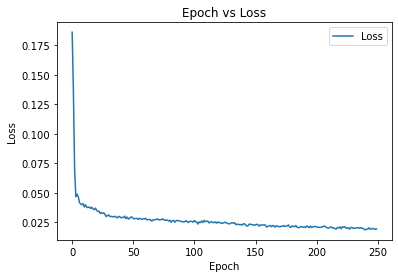

In [64]:
plt.plot(epochArr, losses, label='Loss')

plt.title('Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

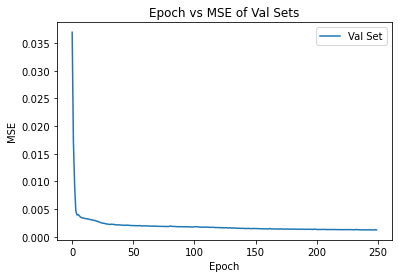

In [65]:
plt.plot(epochArr, mseAtEpochForVal, label='Val Set')

plt.title('Epoch vs MSE of Val Sets')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [66]:
print('Min MSE Val Set: ' + str(min(mseAtEpochForVal)))
mseTestSet = mseTest(testDataloader, model, device)
print("MSE Test Set: ",mseTestSet)

Min MSE Val Set: 0.0012458158364583797
MSE Test Set:  0.0009334414904146186
